# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Data Loading and Exploration

Epoch 1/100


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0285 - val_loss: 7.1947e-04
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 5.3393e-04
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 4.3594e-04
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 6.8958e-04
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 4.0559e-04
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 3.4969e-04
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 8.2351e-04
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 2.7815e-04
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 5.4892e-04
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 3.5684e-04
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 5.5414e-04
Epoch 12/100
94/94 ━━━━━━━━━━━━

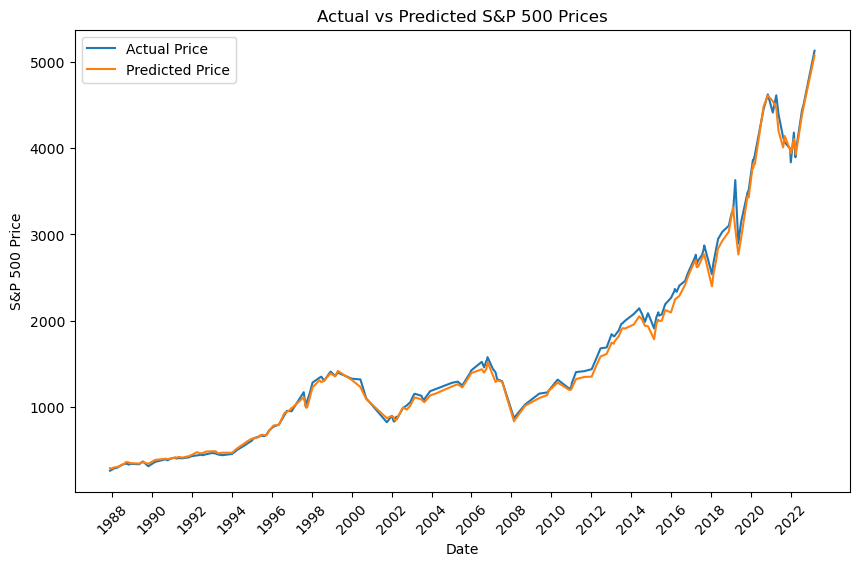

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('output.csv')

# Extract the features and the target variable
features = data.drop(columns=['snp', 'date', 'year', 'month', 'day', 'label'])
target = data['snp']
dates = data['date']  # Extract the dates

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Normalize the target variable
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Create sequences for the LSTM model
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    indices = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(target[i+sequence_length])
        indices.append(i+sequence_length)
    return np.array(sequences), np.array(labels), np.array(indices)

sequence_length = 10  # This can be tuned
X, y, indices = create_sequences(scaled_features, scaled_target, sequence_length)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp, indices_train, indices_temp = train_test_split(X, y, indices, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, indices_val, indices_test = train_test_split(X_temp, y_temp, indices_temp, test_size=0.5, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the original dates for the test set
test_dates = dates.iloc[indices_test]

# Sort the values for plotting
sorted_indices = np.argsort(test_dates)
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
dates_sorted = test_dates.iloc[sorted_indices]

# Convert dates to datetime for easier plotting
dates_sorted = pd.to_datetime(dates_sorted)

# Plot predictions vs actual values, with original dates
plt.figure(figsize=(10, 6))
plt.plot(dates_sorted, y_test_sorted, label='Actual Price')
plt.plot(dates_sorted, y_pred_sorted, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.legend()

# Set x-axis major ticks to every second year
years = pd.date_range(start=dates_sorted.min(), end=dates_sorted.max(), freq='2Y')
plt.xticks(years, [year.year for year in years], rotation=45)

# Add a title to the plot
plt.title('Actual vs Predicted S&P 500 Prices')

plt.show()